# Monte carlo simulation for earthquakes

#### ESCAPE 2022

In [1]:
# standard import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# for Monte Carlo simulation and visualization
import emcee
import corner

# for parallelization
from multiprocessing import Pool

# import statements specific to our problem.
import fault_model

# other configuration steps
%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)


During the last lab, we experimented with finding a best-fitting fault model to explain the GPS data, for example from the Ridgecrest earthquake. There are a lot of parameters to fit, and while the model could sometimes do a good job, it was hard to know how large the uncertainties were. Monte Carlo simulation is a good way to estimate both the parameters and their uncertainties at the same time. The goal is to generate random samples whose distribution reflects the uncertainties in our model parameters accurately.

## Example 1: Line fitting

This example follows the tutorial found at https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html, but modified for our problem

There is much more information in that tutorial, so read up to learn more!

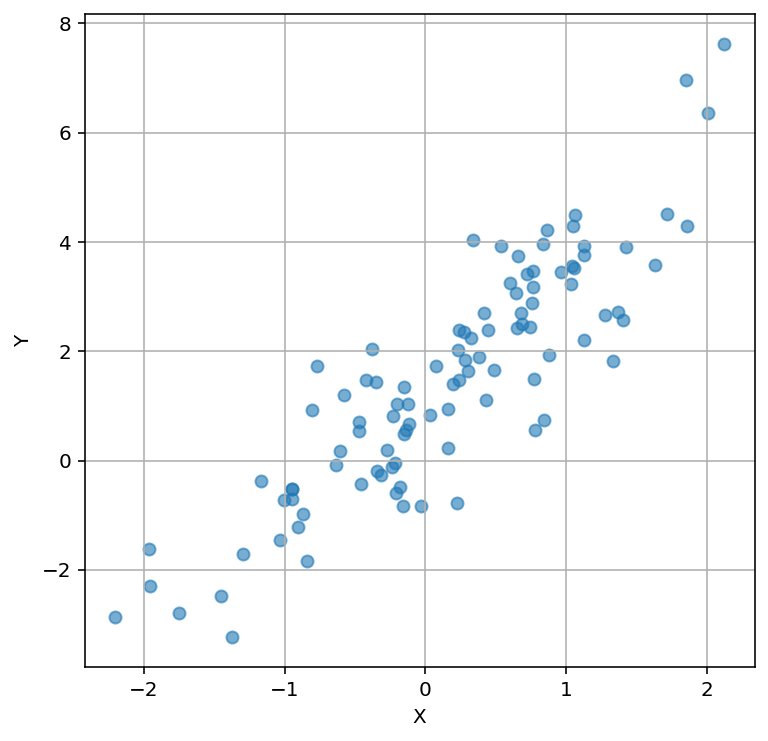

In [2]:
# True parameter values
alpha = 1 
beta = 2
sigma = 1

# Size of dataset
size = 100

# Predictor variable
X = np.random.randn(size)

# Simulate outcome variable
Y = alpha + beta * X + rng.normal(size=size) * sigma

# simulate y errors
Yerr = sigma*np.ones(size)

# plot the simulated data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.scatter(X, Y, alpha=0.6)
axes.set_ylabel("Y")
axes.set_xlabel("X");
axes.grid()

### First step: setup our sampling functions

In [3]:
# define our model here - in this case, just a line. 
def model_line(params,x):
    # this first line "unpacks" the list [params] into elements. 
    # An easier way to pass many variables to a function.
    alpha,beta = params
    # Compute the model, and return the y values
    model = alpha + beta*x
    return model

# "log likelihood" function for the sampler
def lnlike_line(params, x, y, yerr):
    # get the predicted model values
    ypred = model_line(params,x)
    # compute the misfit - sum of the residuals squared, scaled by the data uncertainties
    misfit = -0.5*np.sum(((y-ypred)/yerr)**2)
    return misfit

# set our priors - we use this to set bounds on the parameters.
# return value is set to negative infinity if any parameters are outside their bounds, otherwise it is zero. 
# this is because we have taken the log() of our probability distribution. So 10^0 = 1, while 10^-np.inf = 0.
# if we wanted gaussian priors, or other types, we could also implement them here instead of bounds.
def lnprior_line(params):
    # define bounds here
    minvals = np.array([-10,-10])
    maxvals = np.array([10,10])
    if any(params-minvals<0) or any(params-maxvals>0): # check if any bounds are exceeded
        return -np.inf
    else:
        return 0.0
    
#finally, this function puts together all the above, to determine the actual log(probability) of a set of parameters.
def lnprob_line(params, x, y, yerr):
    prior = lnprior_line(params)
    if np.isinf(prior):
        return -np.inf
    else:
        return prior + lnlike_line(params, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood
    

### Next: run the sampler

In [4]:
# function to run the sampler   
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    # start the timer
    tstart = time.time()

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    # end the timer
    tend = time.time()

    print("Done! Sampling took %f seconds." %(tend-tstart))
    return sampler, pos, prob, state

# collect our variables to feed this function:
# 1. package our input x,y,yerr data together:
data = (X,Y,Yerr)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 10
niter = 1000

# 3. set initial guesses for each random walk
initial=[0,0]
# use this code to set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob_line,data)

Running burn-in...
Running production...
Done! Sampling took 0.710163 seconds.


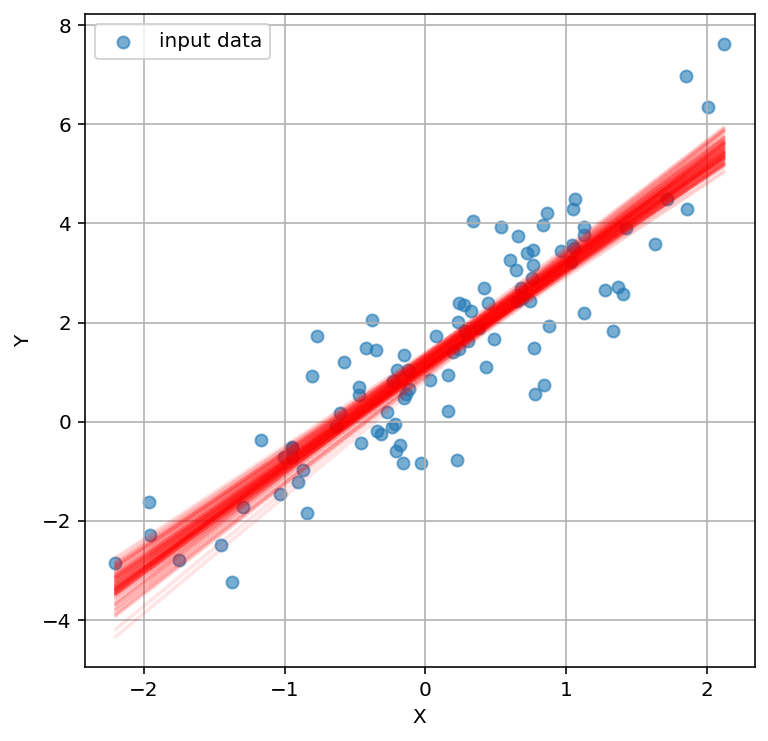

In [5]:
# plot some of the samples, selected at random
plt.figure(figsize=(6,6))
plt.ion()
plt.grid()
plt.scatter(X,Y,label='input data', alpha=0.6)
samples = sampler.flatchain
for params in samples[np.random.randint(len(samples), size=100)]: # plot 100 random samples
    plt.plot(X, model_line(params, X), color="r", alpha=0.1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


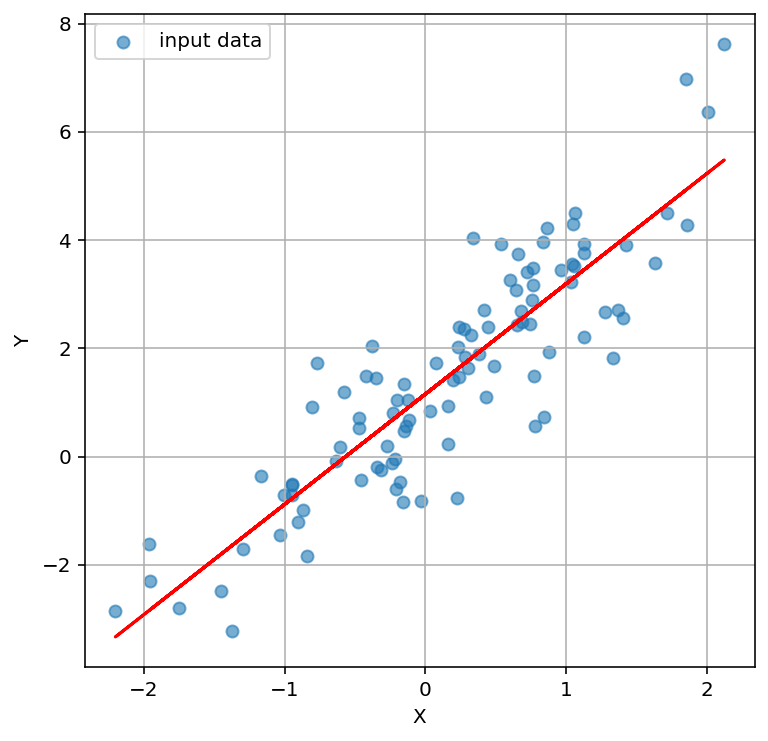

Best fit:  [1.15389184 2.03661876]


In [6]:
# plot the best fitting sample
samples = sampler.flatchain
params_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model_line(params_max,X)

plt.figure(figsize=(6,6))
plt.ion()
plt.grid()
plt.scatter(X,Y,label='input data', alpha=0.6)
plt.plot(X, best_fit_model, color="r")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

print ('Best fit: ',params_max)

### Plot the distribution of the samples for each parameter
We use the 'corner' python library for plotting the probability distributions in a nice way - lots more in the documentation: https://corner.readthedocs.io/en/latest/api/

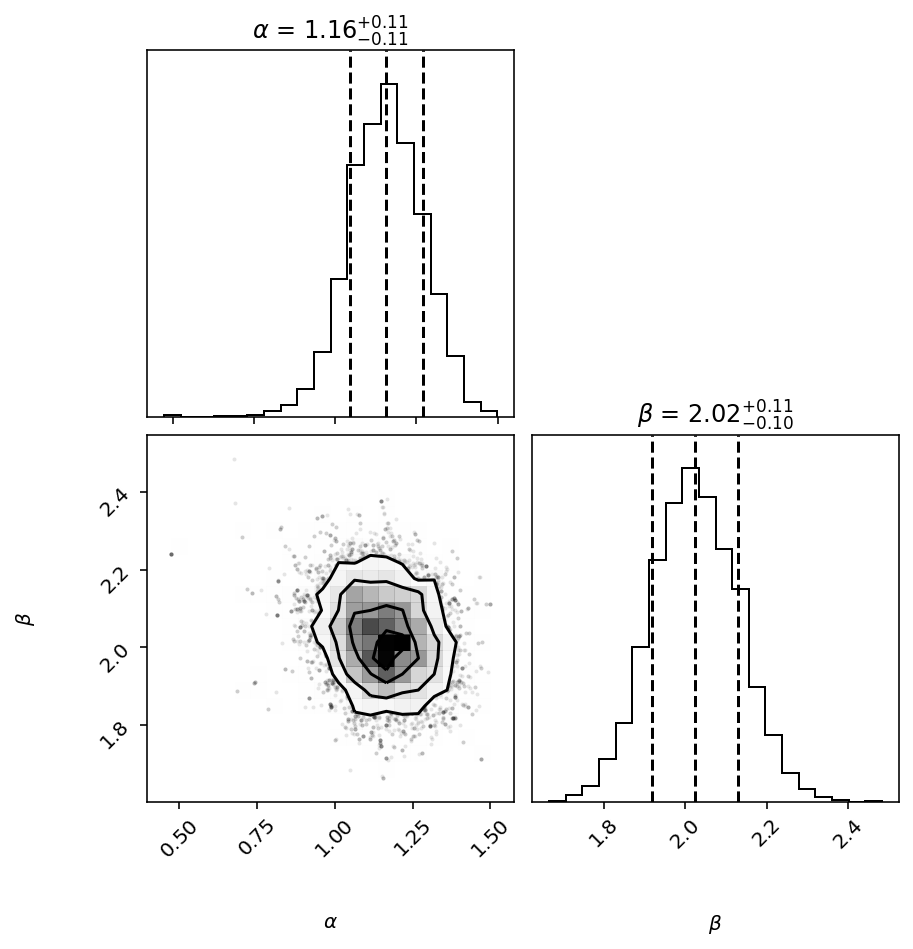

In [7]:
# plot the PDFs of the samples
labels = [r'$\alpha$',r'$\beta$'] # this special format allows greek lettering.
myFig=plt.figure(figsize=(7,7))
fig = corner.corner(samples,show_titles=True,bins=20,use_math_text=True,fig=myFig,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

## Example 2: GPS data and fault model

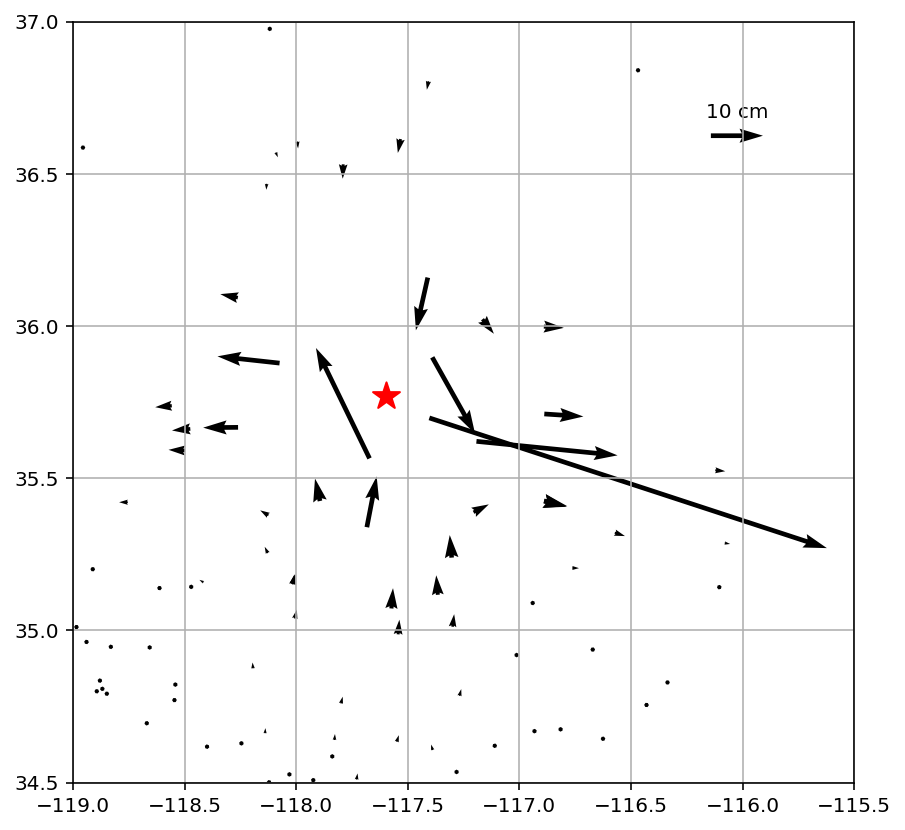

In [8]:
# load GPS data
gpsdata = pd.read_csv('GPS_Ridgecrest.csv')

# I will convert them all to arrays at the start.
gpslon = np.asarray(gpsdata["X"])
gpslat = np.asarray(gpsdata["Y"])
gps_dE = np.asarray(gpsdata["E"])
gps_dN = np.asarray(gpsdata["N"])

#the Ridgecrest data do not have vertical motions, so we set them to zero..
gps_dU = 0.*gps_dE

# create a single vector with the locations to pass to the function
gps_locations=np.append(gpslon,gpslat)

# we also create a single vector that has all the GPS data in it
# the layout of this vector is [E,N,U] for each point. For example, with n points:
#gps_displacements = [E1,N1,U1,E2,N2,U2,...,En,Nn,Un]
# for this, we need to know how many GPS points there are.
Ngps = np.size(gpslon)
# now, create a blank vector of the right length
gps_displacements=np.empty((3*Ngps,),dtype=float)
# fill it up, with indices representing every third item
gps_displacements[0::3] = gps_dE
gps_displacements[1::3] = gps_dN
gps_displacements[2::3] = gps_dU

# gps uncertainties - use fake data here
gps_err = np.ones(np.size(gps_displacements))

# create a plot of the data
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
vecscale = 150
q = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
ax.quiverkey(q,X=0.85,Y=0.85,U=10, label ='10 cm')
plt.show()

In [9]:
# we define our fault modeling function in a separate file, mcmc_fault.py.
# because we may need to edit some parameters in this file while working, 
# it's nice if we can cause jupyter to re-load the module automatically whenever we change it. 
# This special jupyter command accomplishes this:
%load_ext autoreload
%autoreload 2

# now, when we import this file, the functions we call from this notebook will stay up to date
import mcmc_fault

In [10]:
# collect our variables to feed the sampler:

# 1. package our input x,y,yerr data together:
data = (gps_locations,gps_displacements,gps_err)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 40
nburn = 100      # these steps are "burned" or thrown away at the beginnning of each walk
niter = 100      # these steps are kept for statistics
# count the total number of steps
singlethread_steps = nwalkers*(nburn+niter)

# 3. set initial guesses for each random walk - using a scipy optimize fit for the initial point.
initial=[35.730677,-117.557194,5500,-40.846756,67.706525,33048.330581,10759.567750,-400.061320,-52.384303]
# use this code to set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0_init = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

# create the sampler - load in the number of walkers, probability function, and data
sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_fault.lnprob_fault, args=data)

# start the timer
tstart = time.time()

print("Running burn-in...")
p0_burn, _, _ = sampler.run_mcmc(p0_init, nburn)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0_burn, niter)

# end the timer
tend = time.time()
singlethread_time = tend-tstart
print("Done! Sampling took %f seconds." %singlethread_time)

Running burn-in...
Running production...
Done! Sampling took 35.980415 seconds.


Best fitting solution:
lat 35.735208, lon -117.551153, depth 5499.919368, strike -42.879822, dip 77.917830, length 33044.190981, width 10754.330278, ss -402.536524, ds -43.562184


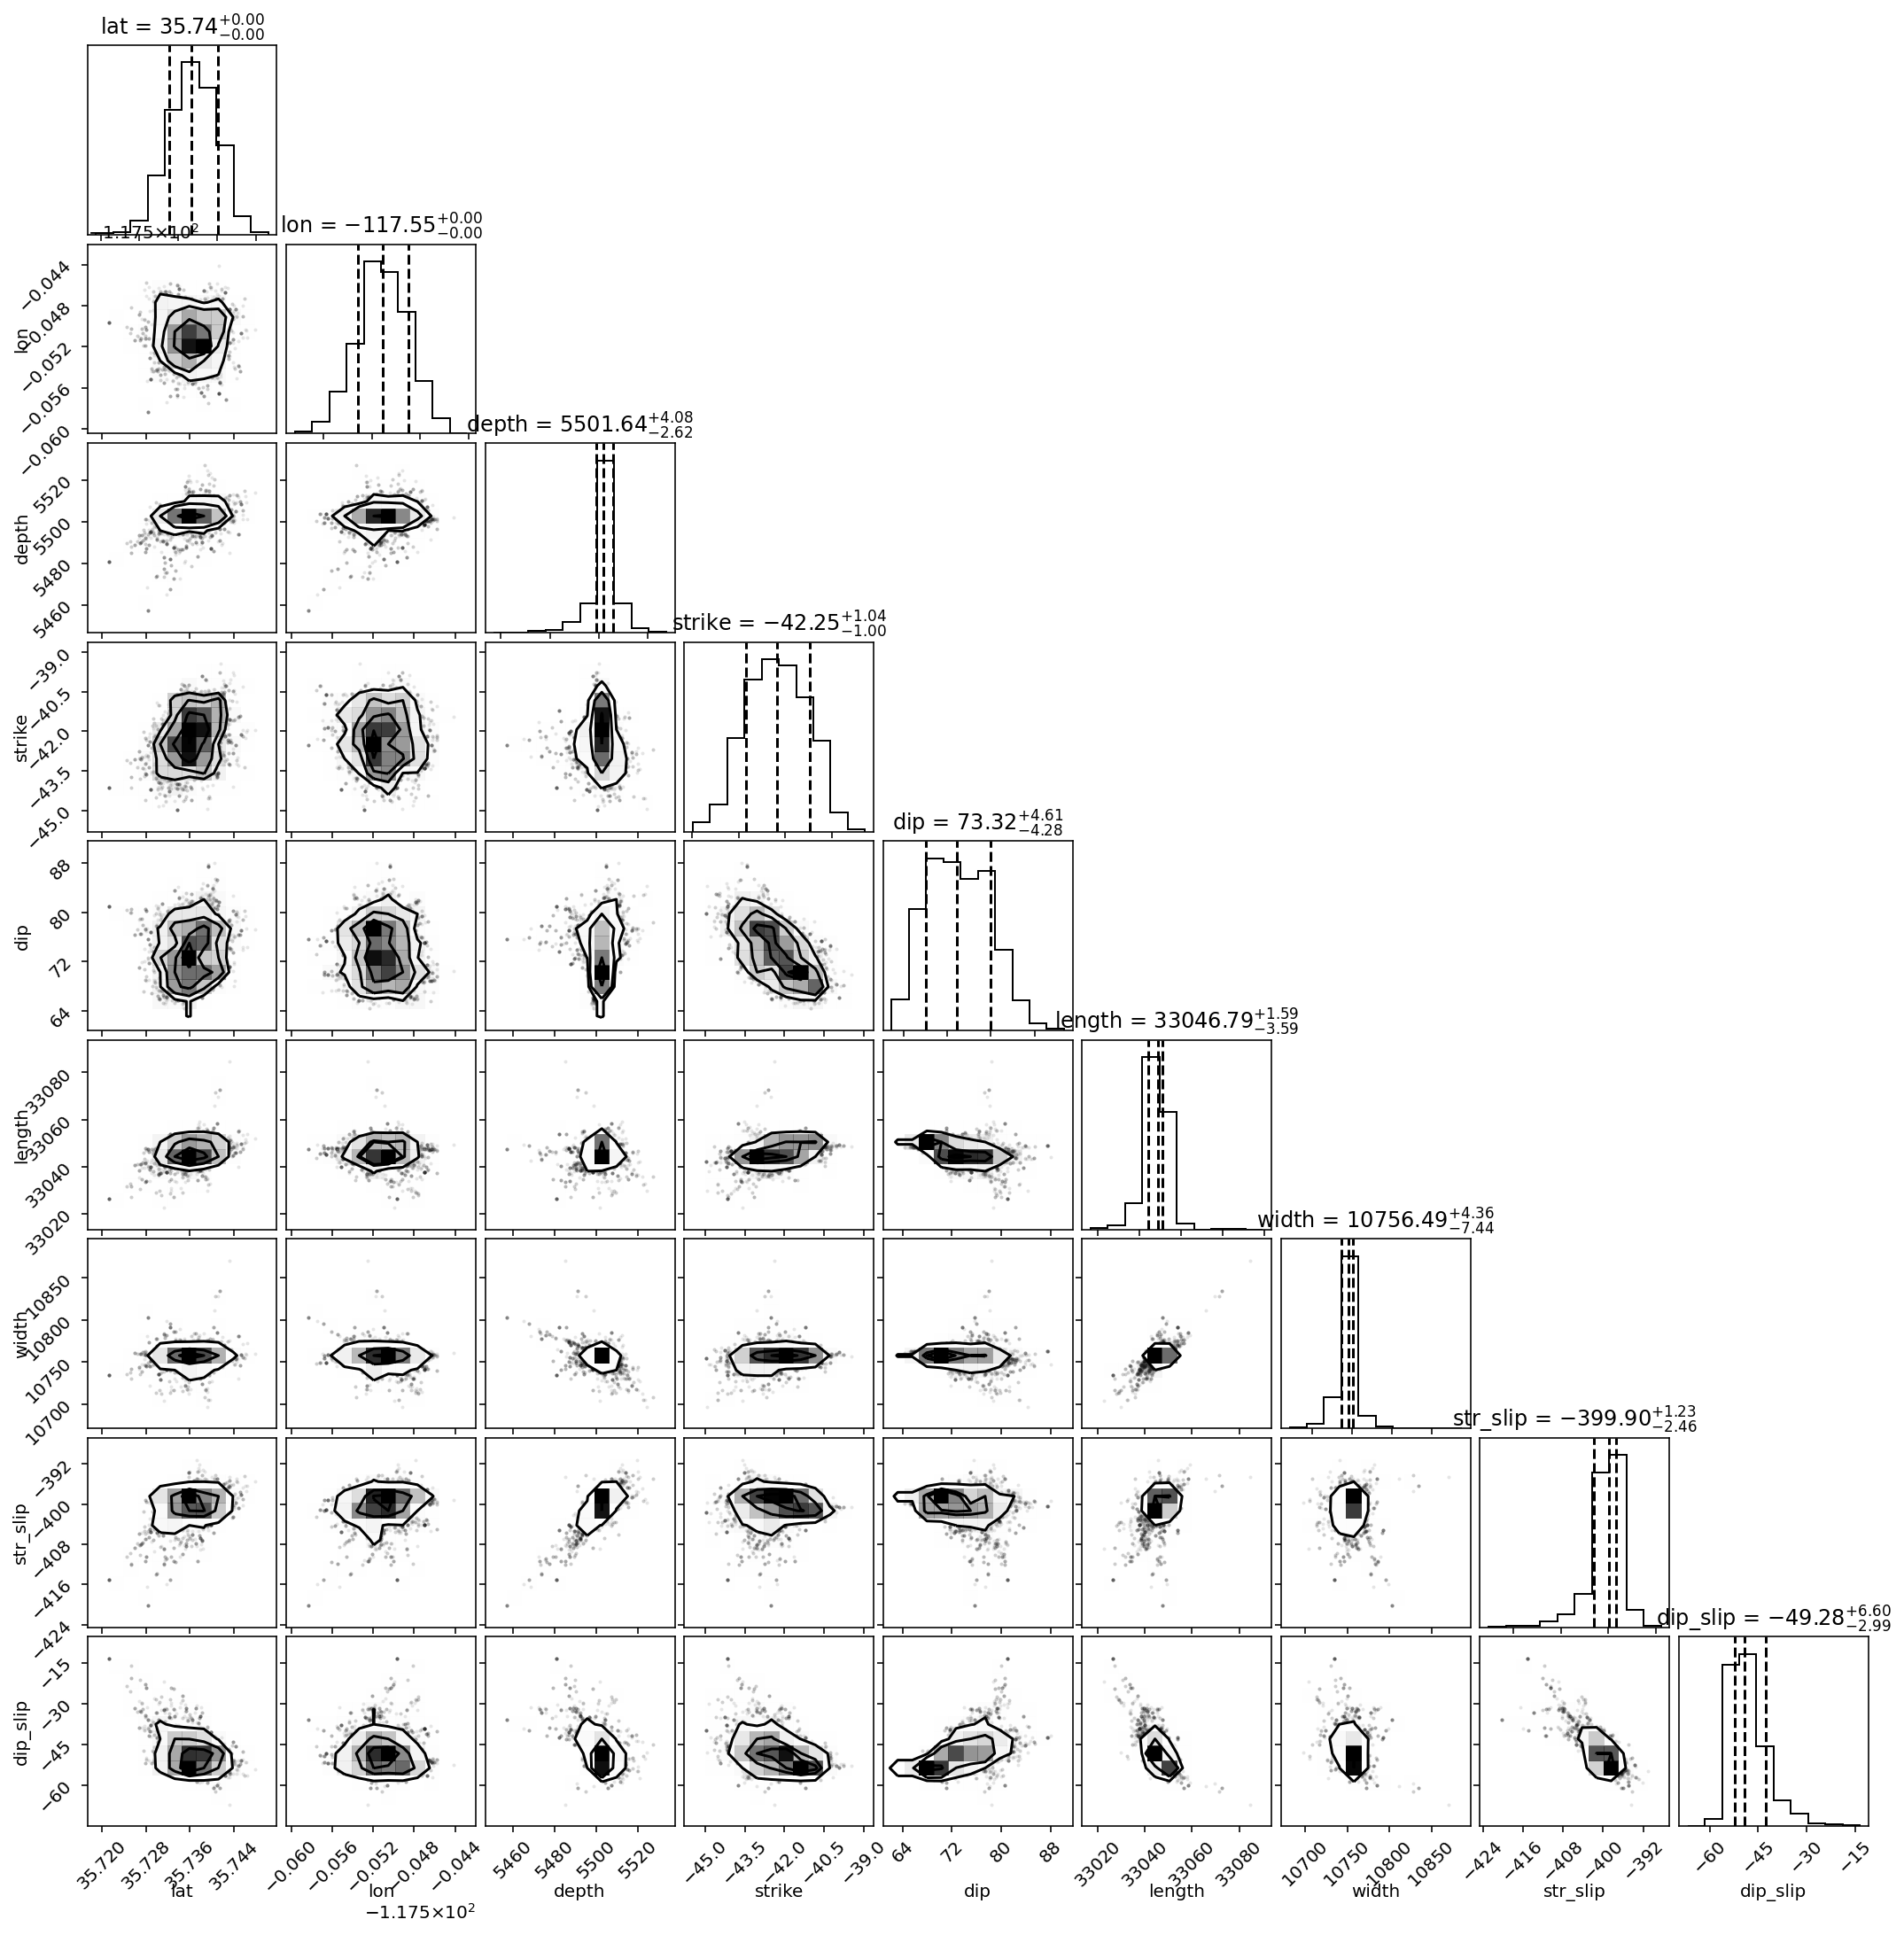

In [11]:
samples = sampler.flatchain
params_max  = samples[np.argmax(sampler.flatlnprobability)]

print('Best fitting solution:')
print('lat %f, lon %f, depth %f, strike %f, dip %f, length %f, width %f, ss %f, ds %f' %tuple(params_max))

# plot the PDFs of the samples
labels = ['lat','lon','depth','strike','dip','length','width','str_slip','dip_slip'] # this special format allows greek lettering.
myFig=plt.figure(figsize=(15,15))
fig = corner.corner(samples,show_titles=True,bins=10,use_math_text=True,fig=myFig,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

Note, you may get some warnings about "too few points to create valid contours", and the probability distributions may look kind of rough.
This is because we have set 'nwalkers' and 'niter' to small values, since this sampling function takes a long time to run. You can try increasing them, but not too much - we will need a faster way to get this to run at high resolution! 

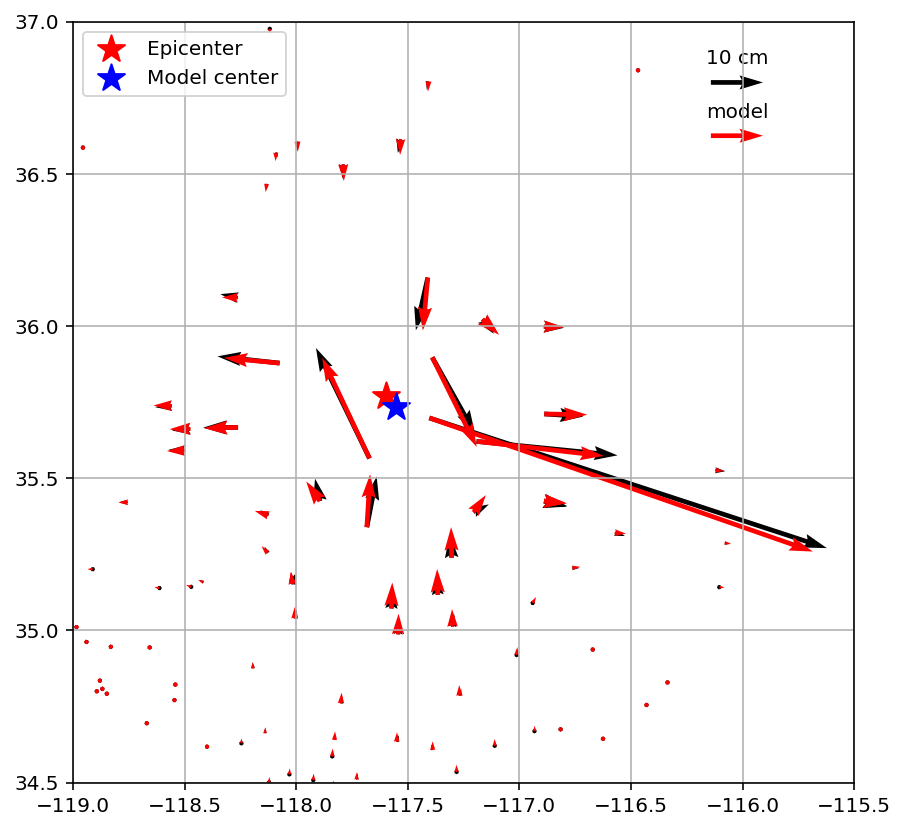

In [13]:
# get the predicted GPS displacements, by running the fault model again with the best fitting parameters (m)
best_fit_model = mcmc_fault.fault_model_for_fitting(params_max,gps_locations)
pred_E = best_fit_model[0::3]
pred_N = best_fit_model[1::3]
# create a plot with results
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)

# note that for a non-geographic plot, we use set_xlim and set_ylim instead of set_extent.
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
q1 = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale) #quiver plot for data
q2 = ax.quiver(gpslon,gpslat,pred_E,pred_N, scale=vecscale,color='red') #quiver plot for model
ax.quiverkey(q1,X=0.85,Y=0.92,U=10, label ='10 cm') # make quiver legend
ax.quiverkey(q2,X=0.85,Y=0.85,U=10, label ='model') # make quiver legend
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
ax.scatter(params_max[1],params_max[0],marker='*',c='b',s=200,label='Model center')
ax.legend(loc='upper left')
plt.show()

### Use multiprocessing to speed things up by running on all available CPUs

Check out much more documentation here: https://emcee.readthedocs.io/en/stable/tutorials/parallel/

In [14]:
# first step: turn OFF multi-threading for the linear algebra, since this interferes with our multi-cpu design for sampling.
import os
os.environ["OMP_NUM_THREADS"] = "1"

nwalkers = 40
nburn = 100
niter = 100
# count the number of steps
multithread_steps = nwalkers*(nburn+niter)

# run everything inside this with Pool() statment to create the "pool" of CPUs automatically when it is needed
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_fault.lnprob_fault, args=data, pool=pool) # add pool here

    # start the timer
    tstart = time.time()

    print("Running burn-in...")
    p0_burn, _, _ = sampler.run_mcmc(p0_init, nburn)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0_burn, niter)

    # end the timer
    tend = time.time()
    multithread_time = tend-tstart

    print("Done! Sampling took %f seconds." %multithread_time)


Running burn-in...
Running production...
Done! Sampling took 11.014398 seconds.


In [15]:
# find out how many cpus we have:
from multiprocessing import cpu_count
ncpu = cpu_count()
print('running with %d cpus' %ncpu)
# what was our speedup?
speedup = (singlethread_time/singlethread_steps)/(multithread_time/multithread_steps)
print('speedup was %f' %speedup)

#on my laptop, I have 8 cpus (actually 8 threads) but only get a 3x speed up. Probably we could optimize this somewhat. Also, it would help to use a bigger computer!

running with 8 cpus
speedup was 3.266671


Best fitting solution:
lat 35.735208, lon -117.551153, depth 5499.919368, strike -42.879822, dip 77.917830, length 33044.190981, width 10754.330278, ss -402.536524, ds -43.562184


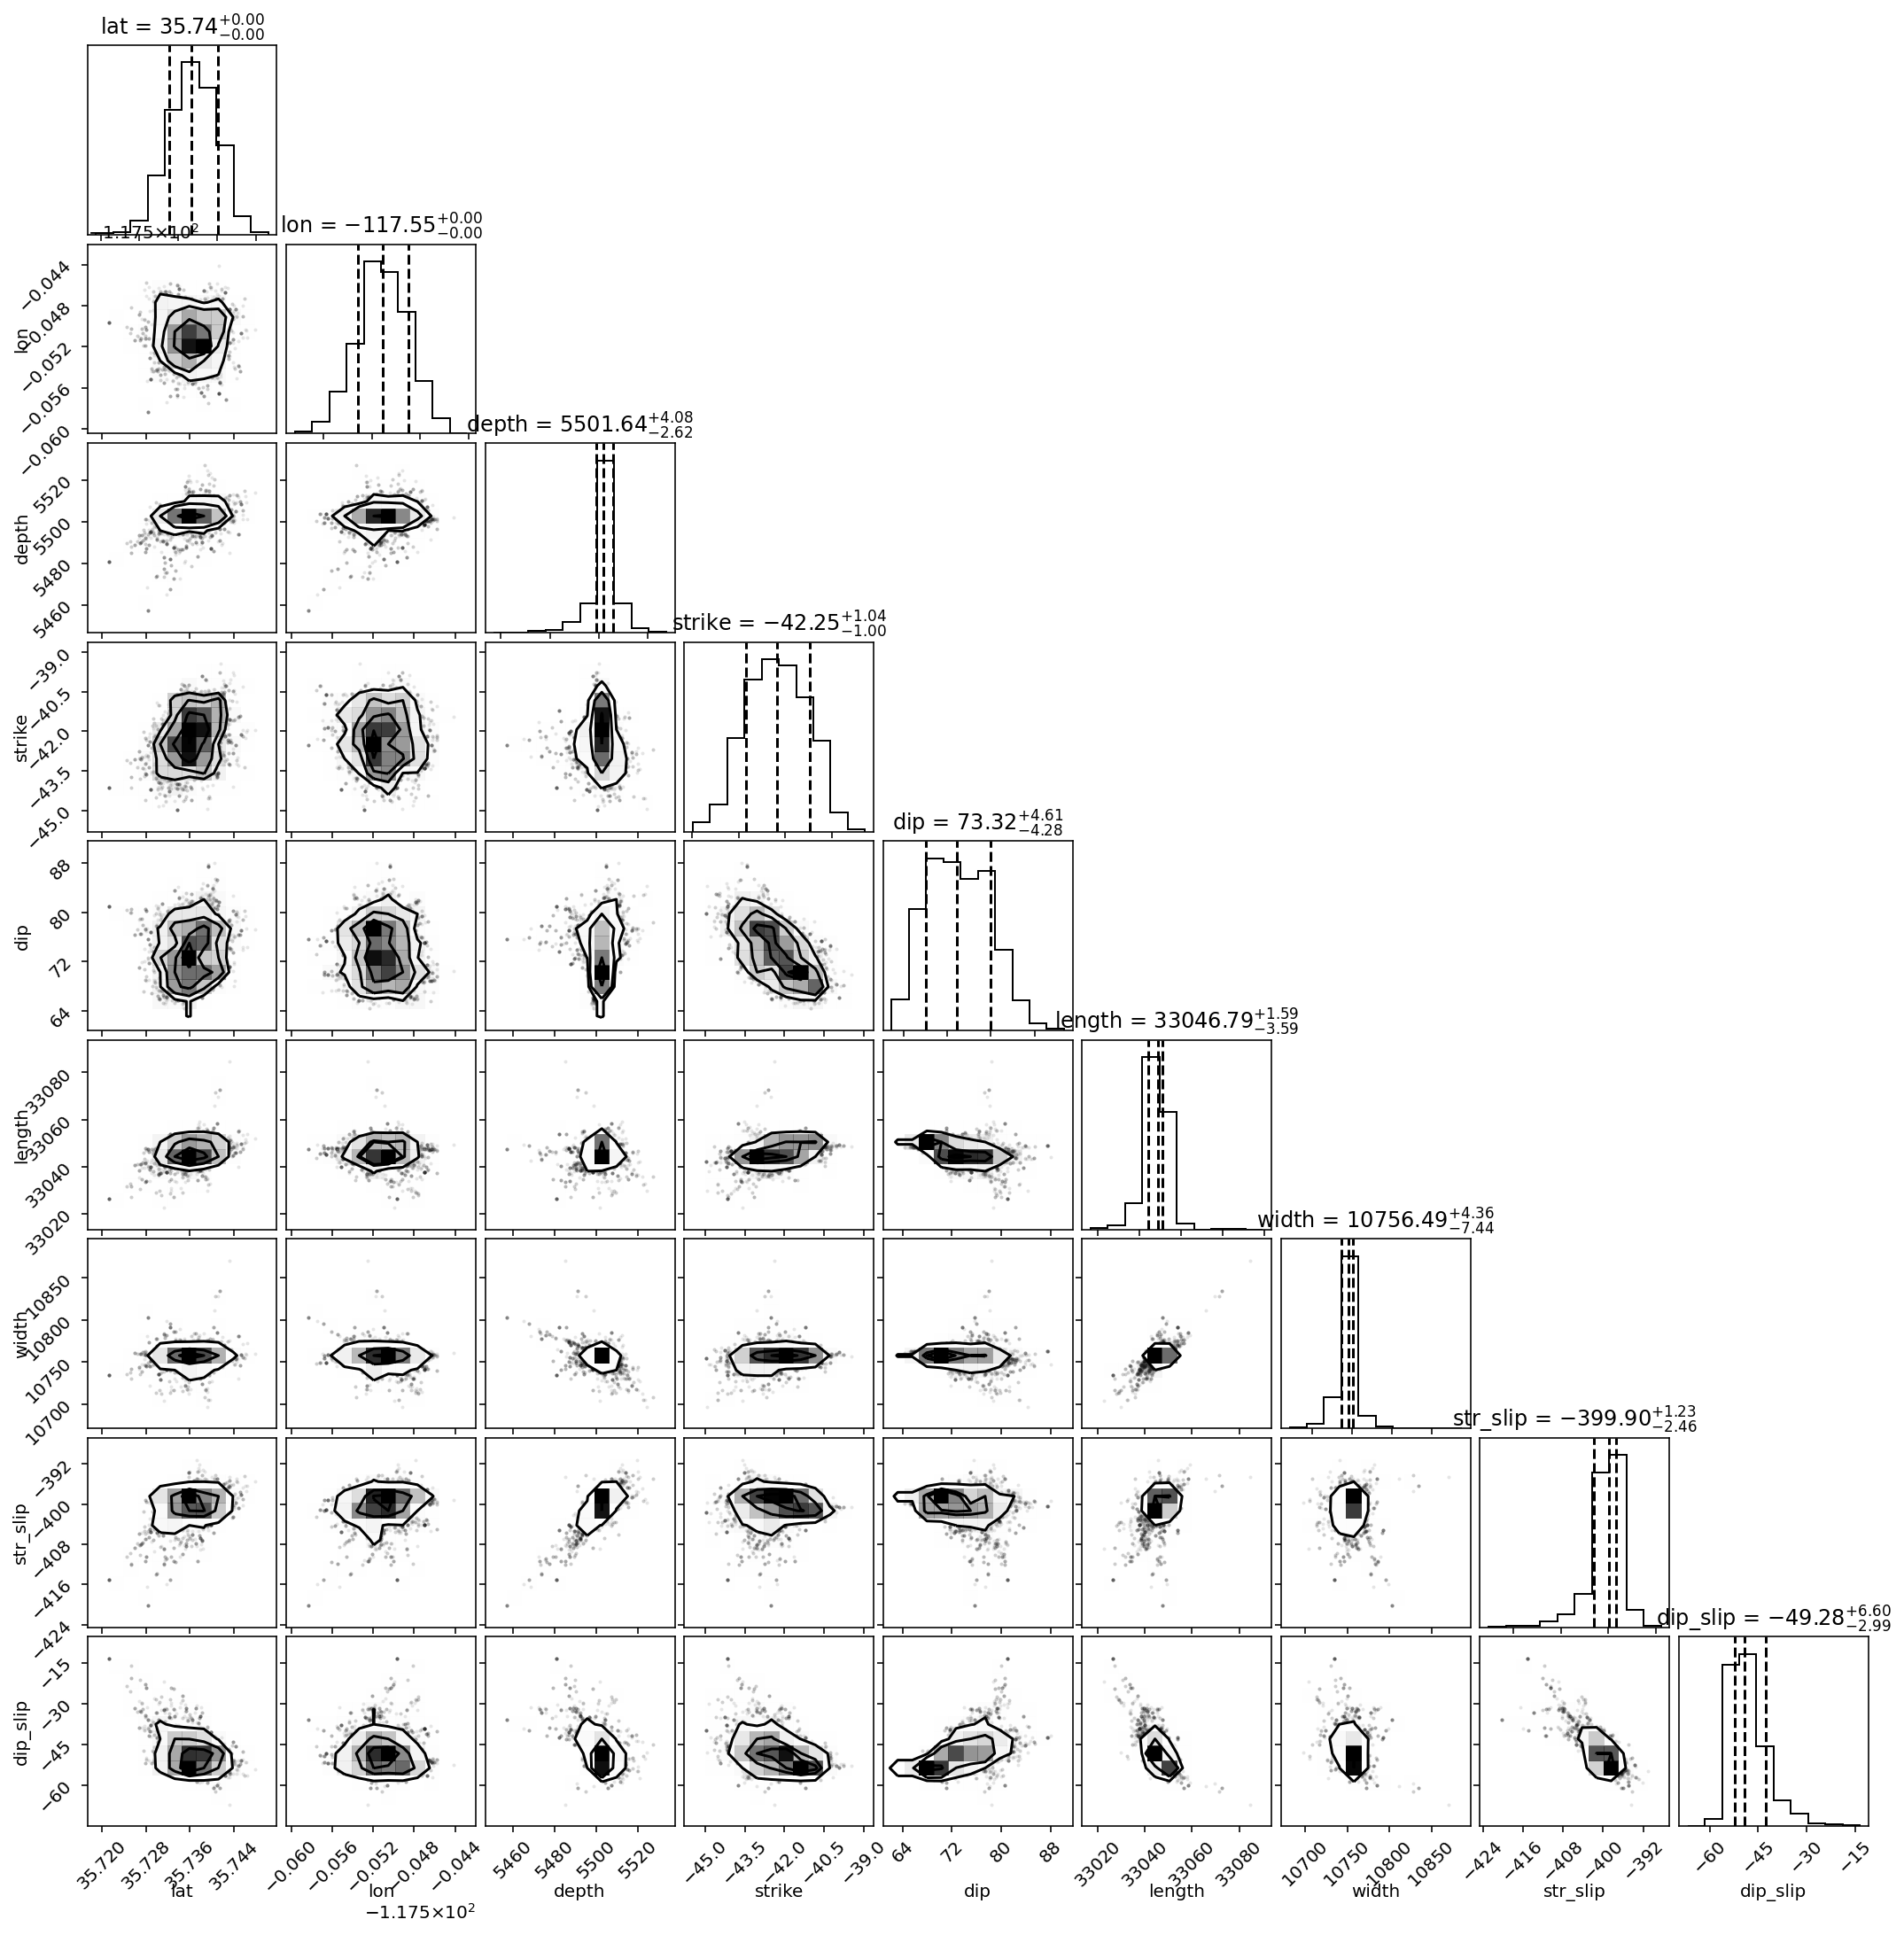

In [16]:
samples = sampler.flatchain
params_max  = samples[np.argmax(sampler.flatlnprobability)]

print('Best fitting solution:')
print('lat %f, lon %f, depth %f, strike %f, dip %f, length %f, width %f, ss %f, ds %f' %tuple(params_max))

# plot the PDFs of the samples
labels = ['lat','lon','depth','strike','dip','length','width','str_slip','dip_slip'] # this special format allows greek lettering.
myFig=plt.figure(figsize=(15,15))
fig = corner.corner(samples,show_titles=True,bins=10,use_math_text=True,fig=myFig,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

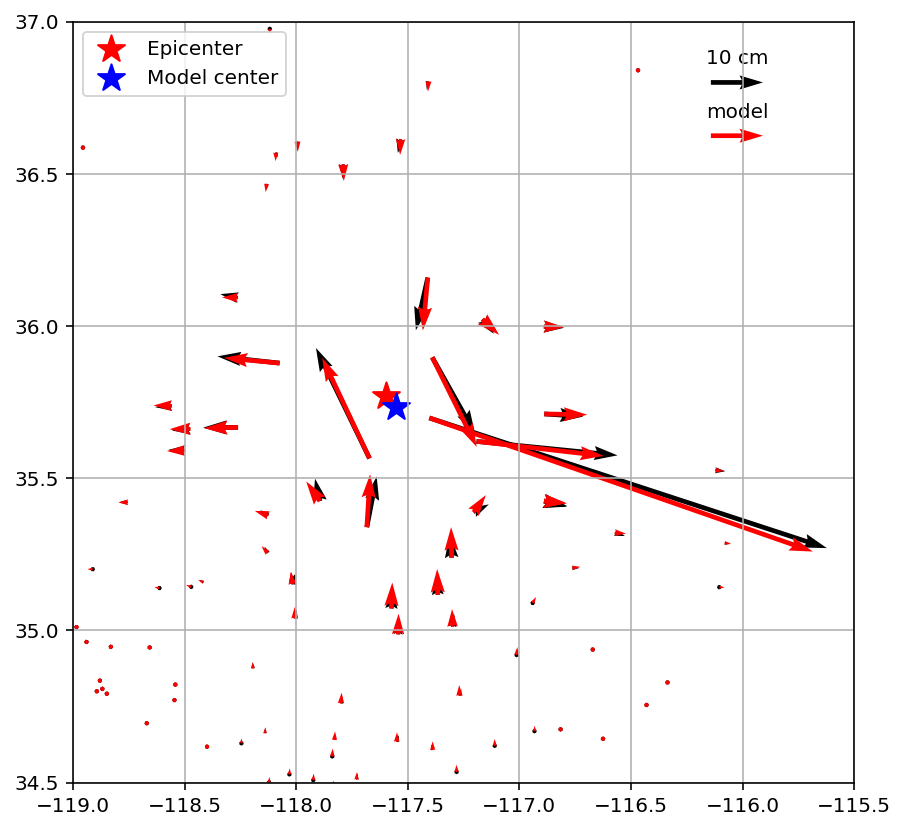

In [18]:
# get the predicted GPS displacements, by running the fault model again with the best fitting parameters (m)
best_fit_model = mcmc_fault.fault_model_for_fitting(params_max,gps_locations)
pred_E = best_fit_model[0::3]
pred_N = best_fit_model[1::3]
# create a plot with results
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)

# note that for a non-geographic plot, we use set_xlim and set_ylim instead of set_extent.
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
q1 = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale) #quiver plot for data
q2 = ax.quiver(gpslon,gpslat,pred_E,pred_N, scale=vecscale,color='red') #quiver plot for model
ax.quiverkey(q1,X=0.85,Y=0.92,U=10, label ='10 cm') # make quiver legend
ax.quiverkey(q2,X=0.85,Y=0.85,U=10, label ='model') # make quiver legend
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
ax.scatter(params_max[1],params_max[0],marker='*',c='b',s=200,label='Model center')
ax.legend(loc='upper left')
plt.show()